In [85]:
import sys
sys.path.append('../')

import numpy as np
import networkx as nx
import itertools
import torch
import torch.nn.functional as F
import torch_sparse
import random 
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
from models.sheaf_base import SheafDiffusion
from models.cont_models import GraphLaplacianDiffusion, DiagSheafDiffusion, BundleSheafDiffusion, ODEBlock
from lib.laplace import build_norm_sheaf_laplacian, remove_duplicate_edges, build_sheaf_difussion_matrix, get_2d_oracle_rotation_angles
from torch_geometric.nn.dense.linear import Linear
from scipy import linalg
from torch_geometric.utils import to_dense_adj, from_networkx
from torch_geometric.nn.conv import GCNConv
from data.heterophilic import generate_random_splits
from models.orthogonal import Orthogonal
from models import laplacian_builders as lb
from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)

import matplotlib as mpl
sns.set(font_scale=1.3)  
sns.set_style("white")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Oracle Model

In [124]:
class StandardODEFunc(nn.Module):
    """Implements Laplacian-based diffusion."""

    def __init__(self, d, L):
        super(StandardODEFunc, self).__init__()
        self.d = d
        self.L = L
        
    def forward(self, t, x):
        return torch_sparse.spmm(self.L[0], self.L[1], x.size(0), x.size(0), -x)
    
class ODEBlock(nn.Module):
    """Module performing the ODE Integration."""

    def __init__(self, odefunc, t, opt):
        super(ODEBlock, self).__init__()
        self.t = t
        self.opt = opt
        self.odefunc = odefunc
        self.set_tol()

    def set_tol(self):
        self.atol = self.opt['tol_scale'] * 1e-7
        self.rtol = self.opt['tol_scale'] * 1e-9
        if self.opt['adjoint']:
            self.atol_adjoint = self.opt['tol_scale_adjoint'] * 1e-7
            self.rtol_adjoint = self.opt['tol_scale_adjoint'] * 1e-9

    def reset_tol(self):
        self.atol = 1e-7
        self.rtol = 1e-9
        self.atol_adjoint = 1e-7
        self.rtol_adjoint = 1e-9

    def forward(self, x, t=None):
        if t is None:
            t = self.t 
        if self.opt["adjoint"] and self.training:
            z = odeint_adjoint(
                self.odefunc, x, t,
                method=self.opt['int_method'],
                options=dict(step_size=self.opt['step_size'], max_iters=self.opt['max_iters']),
                adjoint_method=self.opt['adjoint_method'],
                adjoint_options=dict(step_size=self.opt['adjoint_step_size'], max_iters=self.opt['max_iters']),
                atol=self.atol,
                rtol=self.rtol,
                adjoint_atol=self.atol_adjoint,
                adjoint_rtol=self.rtol_adjoint)
        else:
            z = odeint(
                self.odefunc, x, t,
                method=self.opt['int_method'],
                options=dict(step_size=self.opt['step_size'], max_iters=self.opt['max_iters']),
                atol=self.atol,
                rtol=self.rtol)
        if t is None:
            z = z[1]
        return z

In [125]:
class OracleSheafDiffusion(SheafDiffusion):
    """Performs diffusion using a sheaf Laplacian with diagonal restriction maps."""

    def __init__(self, edge_index, labels, args):
        super(OracleSheafDiffusion, self).__init__(edge_index, args)
        self.labels = labels
        self.lin2 = nn.Linear(self.hidden_dim, self.output_dim)
        
        angles = get_2d_oracle_rotation_angles(edge_index, labels)
        print("All angles", angles.unique())

        laplacian_builder = lb.NormConnectionLaplacianBuilder(
            self.graph_size, edge_index, d=self.d, orth_map='euler')
        self.L, _ = laplacian_builder(angles)

        self.odefunc = StandardODEFunc(self.d, self.L)
        self.odeblock = ODEBlock(self.odefunc, self.time_range, args)
                

    def forward(self, x, t=None):
        if self.t > 0:
            x = x.view(self.graph_size * self.final_d, -1)
            x = self.odeblock(x, t)
        if t is not None:
            return x
        
        x = x.view(self.graph_size, -1)
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)

### Build dataset

In [156]:
def create_graph_dataset(num_nodes=120, max_edges_per_V_node=6, input_features=5, inter_p=1.0, classes=3, num_edges=500):
    assert 0 <= inter_p <= 1.0
    # We randomly generate graphs until we produce a connected one
    graph = nx.Graph()

    # Partition the graph into two sets. 
    nodes = np.arange(0, num_nodes).reshape(classes, -1)
    graph.add_nodes_from(nodes.flatten())

    # Randomly generate edges between nodes
    edges = []
    for _ in range(num_edges):
        current_class = random.randint(0, classes-1)
        nodes_from_other_classes = np.concatenate((nodes[:current_class, :],nodes[current_class+1:, :]))
        v_node = random.choice(nodes[current_class])

        sample = np.random.uniform(0, 1)
        if sample <= inter_p:
            u_node = random.choice(nodes_from_other_classes.flatten())
        else:
            u_node = random.choice(nodes[current_class])
        if u_node != v_node:
            edges.append((v_node, u_node))
    graph.add_edges_from(edges)
    assert nx.is_connected(graph)
        
    # Convert the graph to a PyTorch geometric data object
    data = from_networkx(graph)

    # Add dummy features to the graph
    # x_V = torch.empty(num_nodes // classes, input_features).normal_(mean=-0.3,std=0.5)
    # x_U = torch.empty(num_nodes // classes, input_features).normal_(mean=0.0,std=0.5)
    # x_W = torch.empty(num_nodes // classes, input_features).normal_(mean=0.3,std=0.5)

    # x = torch.cat((x_V, x_U, x_W), dim=0)
    # data.x = x
    data.x = torch.empty(num_nodes, input_features).uniform_(-1.0, 1.0) 
    # data.x = torch.ones(size=(num_nodes, input_features))
                        
    # Add labels
    y = torch.arange(classes).view(-1, 1).tile(1, num_nodes // classes).view(-1)
    data.y = y
    
    # Meta
    data.num_nodes = num_nodes
    data.in_features = input_features
    
    return data, graph

In [177]:
inter_p=0.6
classes = 4
data, graph = create_graph_dataset(inter_p=inter_p, classes=classes, input_features=2)
print(data.y.unique())
print(data.y)

tensor([0, 1, 2, 3])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])


In [180]:
times = torch.arange(0, 11, step=1.0)
seeds = 1

args = {
    'hidden_channels': 1,
    'layers': -1,
    'device': torch.device('cpu'),
    'normalised': True,
    'deg_normalised': False,
    'linear': True,
    'input_dropout': 0.0,
    'dropout': 0.0,
    'left_weights': False,
    'right_weights': False,
    'use_act': False,
    'second_linear': False,
    'add_lp': False,
    'add_hp': False,
    'sheaf_act': 'tanh',
    'tol_scale': 1.0,
    'int_method': 'dopri5',
    'step_size': None,
    'max_iters': None,
    'tol_scale_adjoint': 1.0,
    'adjoint_method': 'euler',
    'adjoint_step_size': None,
    'edge_weights': False,
    'orth': 'householder',
    'adjoint': False,
    'd': 2,
    'orth': 'euler',
    'graph_size': data.num_nodes,
    'input_dim': 2,
    'output_dim': classes,
    'max_t': 1.0,
}

#### Visualise diffusion

In [181]:
# Produce a single integration
model = OracleSheafDiffusion(data.edge_index, data.y, args) 
model.eval()

viz_times = torch.arange(0, 27, step=0.5)
states = model(data.x, viz_times)
states = states.view(viz_times.size(0), data.num_nodes, 2)
print(states.size())

All angles tensor([-2.3562, -1.5708, -0.7854,  0.0000,  0.7854,  1.5708,  2.3562])
torch.Size([54, 120, 2])


In [152]:
print(states[0, 0])
# print(states[180, 0])
print(np.unique(data.y.numpy()))

# problems = set()
# for i in range(600):
#     for t in range(1, 200):
#         if torch.allclose(states[0, i], states[t, i]):
#             problems.add(i)
# print(problems)

tensor([ 0.8793, -0.3671])
[0 1 2 3 4 5]


In [153]:
import matplotlib.animation as animation
class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, states, y):
        self.states = states 
        c = []
        
        palette = itertools.cycle(sns.color_palette("colorblind"))
        colors = {}
        for i in range(len(y)):
            if y[i] not in colors:
                colors[y[i]] = next(palette)
            c.append(list(colors[y[i]]))
        self.c = np.array(c)
            
        self.i = 0
        self.numpoints = len(states)
        self.stream = self.data_stream()

        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots(figsize=(8,6))
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, frames=self.numpoints-2, interval=150, 
                                           init_func=self.setup_plot, repeat=True)

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        xy = next(self.stream)
        self.scat = self.ax.scatter(xy[:, 0], xy[:, 1], c=self.c)
        # self.ax.axis([-0.8, 0.8, -0.8, 0.8])
        # self.ax.relim() 
        # self.ax.autoscale_view()
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

    def data_stream(self):
        """Plot diffusion states"""
        while True:
            xy = self.states[self.i, :, :]
            yield xy

    def update(self, i):
        """Update the scatter plot."""
        self.i = i
        xy = next(self.stream)
        
        # Set x and y data...
        self.scat.set_offsets(xy)
        # self.scat.set_sizes(np.ones(shape=(xy.shape[1],)) + 100)
        # self.scat.set_array(self.c)
        
        margin = 0.3
        self.ax.set_ylim([xy[:, 0].min() - margin * abs(xy[:, 0].min()), xy[:, 0].max() + margin * abs(xy[:, 0].max())])
        self.ax.set_xlim([xy[:, 1].min() - margin * abs(xy[:, 1].min()), xy[:, 1].max() + margin * abs(xy[:, 1].max())])
        
        # pos = dict() 
        # for index, value in enumerate(xy):
        #     pos[index] = value
        # nx.draw_networkx_edges(graph, pos=pos, ax=self.ax)

        
        # self.ax.relim()
        # self.ax.autoscale_view()

        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

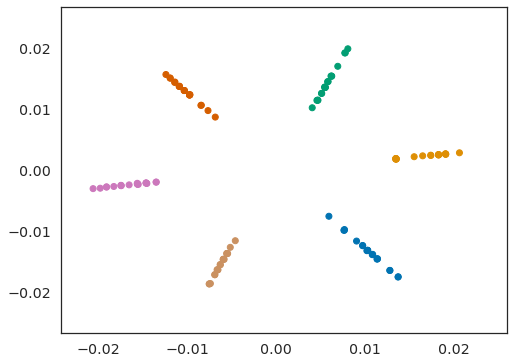

In [154]:
states_np = states.detach().numpy()
y_np = data.y.numpy()
a = AnimatedScatter(states_np, y_np)
a.ani.save('img/diffusion.gif', writer='pillow', fps=10)
plt.show()

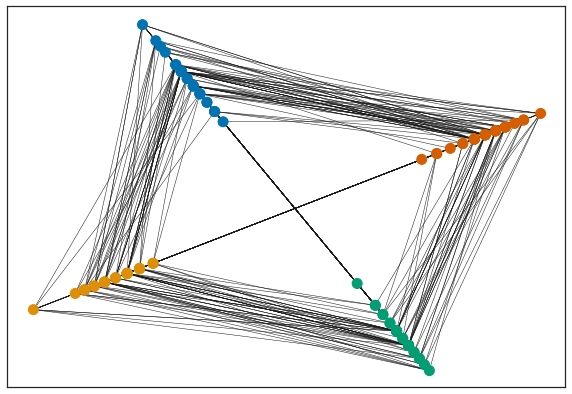

In [182]:
# Build plot
fig, ax = plt.subplots(figsize=(10, 7))

states_np = states.detach().numpy()
y_np = data.y.numpy()
palette = itertools.cycle(sns.color_palette("colorblind"))
colors = {}
c = []
for i in range(len(y_np)):
    if y_np[i] not in colors:
        colors[y_np[i]] = next(palette)
    c.append(list(colors[y_np[i]]))
c = np.array(c)

def update(num):
    ax.clear()
    xy = states_np[num, :, :]
    
    pos = dict() 
    for index, value in enumerate(xy):
        pos[index] = value
        
    nx.draw_networkx(graph, pos=pos, ax=ax, node_color=c, with_labels=False, node_size=100, width=0.5)
#     nx.draw_networkx_edges(graph, pos=pos, ax=ax)
#     ax.scatter(xy[:, 0], xy[:, 1], c=c)
    
    margin = 0.1
    ax.set_ylim([xy[:, 1].min() - margin * abs(xy[:, 1].min()), xy[:, 1].max() + margin * abs(xy[:, 1].max())])
    ax.set_xlim([xy[:, 0].min() - margin * abs(xy[:, 0].min()), xy[:, 0].max() + margin * abs(xy[:, 0].max())])


a = animation.FuncAnimation(fig, update, frames=len(states_np), interval=150, repeat=True)
a.save('img/graph_diffusion.gif', writer='pillow', fps=10)
plt.show()